In [2]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cartopy.crs as ccrs

In [3]:
#historical run
fn_sic_cmip6_hist = '/net/pc200037/nobackup/users/linden/cmip6data/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/SImon/siconc/gn/*.nc'
sic_cmip6_hist = xr.open_mfdataset(fn_sic_cmip6_hist)

#ssp585
fn_sic_cmip6_585 = '/net/pc200037/nobackup/users/linden/cmip6data/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp585/r1i1p1f1/SImon/siconc/gn/*.nc'
sic_cmip6_585 = xr.open_mfdataset(fn_sic_cmip6_585)

#lcic historical
fn_sic_lcic_hist = '/net/pc200037/nobackup/users/linden/ecearth-runs/lcic/v001/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/SImon/siconc/gn/v20230713/*.nc'
sic_lcic_hist = xr.open_mfdataset(fn_sic_lcic_hist)

#lcic ssp585
fn_sic_lcic_585 = '/net/pc200037/nobackup/users/linden/ecearth-runs/lcic/v001/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp585/r1i1p1f1/SImon/siconc/gn/v20230714/*.nc'
sic_lcic_585 = xr.open_mfdataset(fn_sic_lcic_585)

#5icu historical
fn_sic_5icu_hist = '/net/pc200037/nobackup/users/linden/ecearth-runs/5icu/v001/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/SImon/siconc/gn/v20230720/*.nc'
sic_5icu_hist = xr.open_mfdataset(fn_sic_5icu_hist)

#5icu ssp585
fn_sic_5icu_585 = '/net/pc200037/nobackup/users/linden/ecearth-runs/5icu/v001/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp585/r1i1p1f1/SImon/siconc/gn/v20230720/*.nc'
sic_5icu_585 = xr.open_mfdataset(fn_sic_5icu_585)

In [4]:
def sic_processer(data, startdate, enddate):
    data_slice = data.siconc.sel(time = slice(startdate, enddate))
    grouped_data = data_slice.groupby('time.month')
    processed_data = grouped_data.mean('time')

    return processed_data

In [5]:
#CMIP6 run
month_mean_rec_sd = sic_processer(sic_cmip6_hist, '1984-01-01', '2014-12-31')
month_mean_fut_sd = sic_processer(sic_cmip6_585, '2070-01-01', '2100-12-31')

#lcic run
month_mean_rec_lcic = sic_processer(sic_lcic_hist, '1984-01-01', '2014-12-31')
month_mean_fut_lcic = sic_processer(sic_lcic_585, '2070-01-01', '2098-12-31')

#5icu run
month_mean_rec_5icu = sic_processer(sic_5icu_hist, '1984-01-01', '2014-12-31')
month_mean_fut_5icu = sic_processer(sic_5icu_585, '2070-01-01', '2098-12-31')


monthnames = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

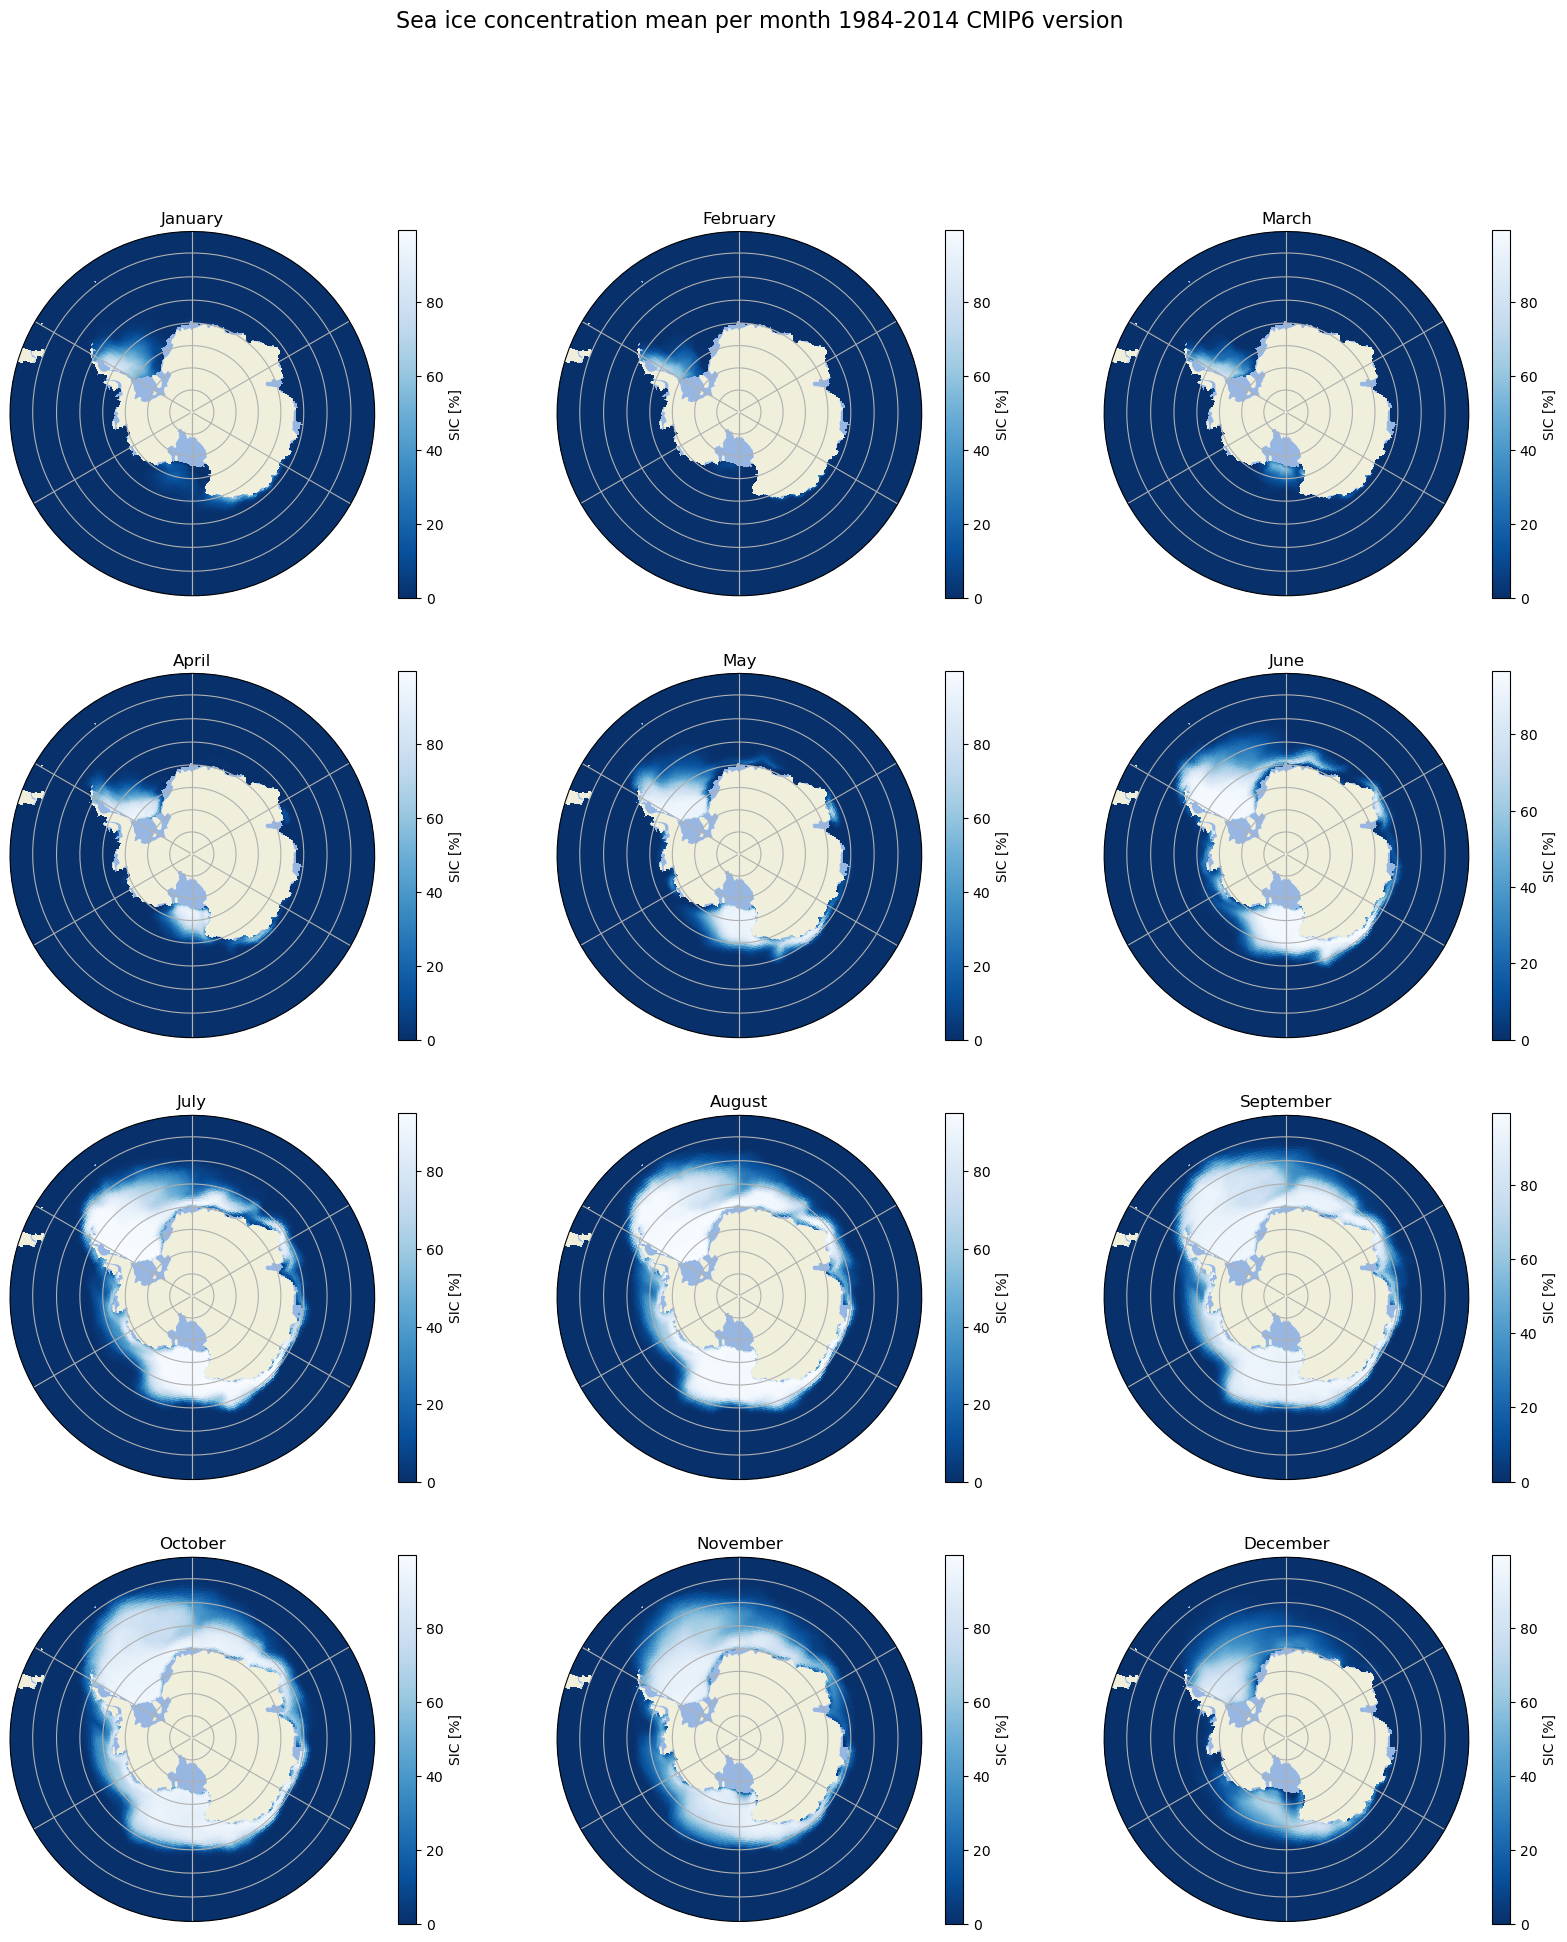

<Figure size 640x480 with 0 Axes>

In [6]:
'''Some older code that plots the monthly mean sea ice concentration. Not very pretty, but perhaps useful if you want to study the local changes in the SIC,
instead of comapring a single month, a maximum or a 30-year mean number.'''

fig = plt.figure(figsize=[20, 22])
fig.suptitle('Sea ice concentration mean per month 1984-2014 CMIP6 version', fontsize = 16)


for i in range(len(month_mean_rec_sd)):
    ax1 = plt.subplot(4, 3, 1+i, projection=ccrs.SouthPolarStereo())
    # Limit the map to -50 degrees latitude and below.
    ax1.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    ax1.add_feature(cartopy.feature.LAND)
    ax1.add_feature(cartopy.feature.OCEAN)
    ax1.gridlines()

    #make circular instead of square plot by setting circular boundaries
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax1.set_boundary(circle, transform=ax1.transAxes)

    #here is the actual plotting, change sic_cmip6_hist here to the data you want to plot.
    im = ax1.pcolormesh(sic_cmip6_hist.longitude, sic_cmip6_hist.latitude,
                        month_mean_rec_sd[i], 
                        cmap='Blues_r',
                        transform=ccrs.PlateCarree())
    plt.title(str(monthnames[i]))
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_label('SIC [%]')
plt.show()
plt.clf()

In [7]:
sizemlf = 2 # change this value to increase or decrease the size of your figure rapidly, text and maps should readjust accordingly.

In [8]:
'''Map plotter function that removes the bulk of the code used for plotting from the code where the figure is made.

It takes the following arguments:

data = specific data from a dataset you want to plot, e.g. a selected of the means over a certain period from a larger dataset.
dataset = the full dataset from which data is derived, has to be provided for the corresponding coordinate variables.
ax = must be specified for the arrangement of the subplots in the full figure.
colormap = specifies the colormap used in the plot.
cmin, cmax = specifies the boundary values for the colormap.
titlestring = takes a string in accolades, this becomes the subplot title.
cbarlabel = takes a string in accolades, this becomes the subplot colorbar label.

Unfortunately I have not managed to plot the sea ice extent boundaries. The problem there when using a function like contourf 
is the break in the data at indices 1 and 362, around 0 degrees E. This causes problematic bahviour as contourf cannot continue
the contour through this boundary easily. There must be a fix for this but I have not found it.'''

def map_plotter(data, dataset, ax, colormap, cmin, cmax, titlestring, cbarlabel): 
    #limiting plot to 50 degrees south and below, adding cartopy features
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.gridlines()
    ax.coastlines()

    # Make circular instead of square plot by setting circular boundaries
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    #plotting 
    im = ax.pcolormesh(dataset.longitude, dataset.latitude,
                    data, 
                    cmap=colormap, vmin = cmin, vmax = cmax,
                    transform=ccrs.PlateCarree())
    ax.set_title(titlestring, fontsize = 10*sizemlf)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbarlabel, fontsize = 8*sizemlf)
    cbar.ax.tick_params(labelsize=8*sizemlf)

    return im

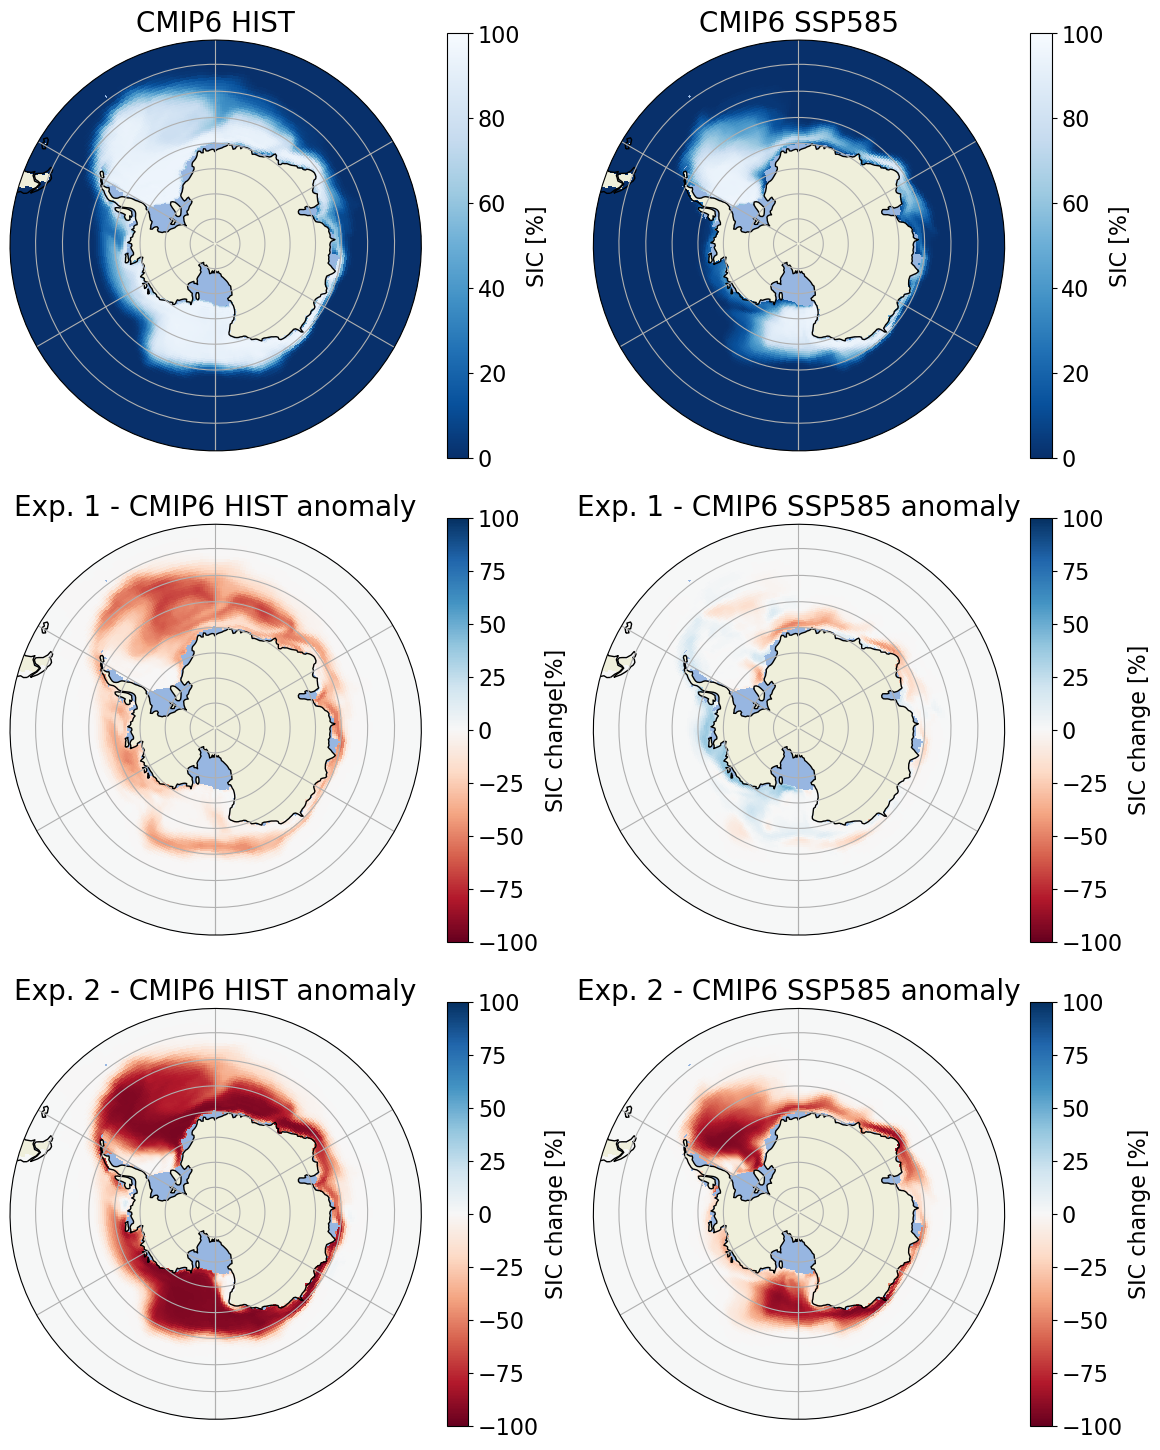

In [9]:
# Create a figure with 6 subplots, 3 by 2
fig, axes = plt.subplots(3, 2, figsize=(6*sizemlf, 8*sizemlf), subplot_kw={'projection': ccrs.SouthPolarStereo()})
fig.tight_layout(pad=2) 

#upper two plots
cmin = 0
cmax = 100
map_plotter(month_mean_rec_sd.isel(month=8), 
            sic_cmip6_hist, axes[0, 0], 'Blues_r', cmin, cmax, 
            'CMIP6 HIST', 'SIC [%]')

map_plotter(month_mean_fut_sd.isel(month=8), 
            sic_cmip6_585, axes[0, 1], 'Blues_r', cmin, cmax, 
            'CMIP6 SSP585', 'SIC [%]')

#middle two plots
cmin = -100
cmax = 100
map_plotter(month_mean_rec_5icu.isel(month=8) - month_mean_rec_sd.isel(month=8), 
            sic_cmip6_hist, axes[1, 0], 'RdBu', cmin, cmax, 
            'Exp. 1 - CMIP6 HIST anomaly', 'SIC change[%]')

map_plotter(month_mean_fut_5icu.isel(month=8) - month_mean_fut_sd.isel(month=8), 
            sic_cmip6_585, axes[1, 1], 'RdBu', cmin, cmax, 
            'Exp. 1 - CMIP6 SSP585 anomaly', 'SIC change [%]')

#lowest two plots
cmin = -100
cmax = 100
map_plotter(month_mean_rec_lcic.isel(month=8) - month_mean_rec_sd.isel(month=8), 
            sic_cmip6_hist, axes[2, 0], 'RdBu', cmin, cmax, 
            'Exp. 2 - CMIP6 HIST anomaly', 'SIC change [%]')

map_plotter(month_mean_fut_lcic.isel(month=8) - month_mean_fut_sd.isel(month=8), 
            sic_cmip6_585, axes[2, 1], 'RdBu', cmin, cmax, 
            'Exp. 2 - CMIP6 SSP585 anomaly', 'SIC change [%]')

plt.tight_layout(pad=1.2*sizemlf)
plt.subplots_adjust(top=0.9)
plt.show()